# Dados

In [4]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import cv2
import shutil
from module import data_read, setup
from torch.utils.data import ConcatDataset

DDR_DIR = Path.cwd() / 'DDR-dataset/DR_grading'
IDRID_DIR = Path.cwd() / 'IDRID-Classificacao'
#FGADR_DIR = Path.cwd() / 'FGADR Dataset/Seg-set'

# Treino
❗❗ Treino com Fine tuning! <br>
❗❗ Duvida: usar one-hot encoding? <br>
❗❗ Plotar numero de imagens por classes; <br>
❗❗ testar softmax; <br>
❗❗ excluir .cache da maquina monstrona; <br>
❗❗ usar transformações de treino para todas as partes do DDR e
transformações de teste para todo o IDRID? <br>
❗❗ acrescentar calculo de tempo

#### Redes:
> VGG16 , ResNet50, MobileNet, EfficientNetB7
#### Métricas:
> Acurácia, Sensibilidade, Precisão, Especificidade, F1-score e Curva ROC

Observações:
Analise de k-fold com o Messidor;
Analise Hold-out com Messidor e IDRID;
Usar DDR ao ives do Messidor;

##### Settings

In [52]:
from torch import nn

num_classes = 5
torch.manual_seed(42)
random_state = 42
k_folds = 5
num_epochs = 2
batch_size = 64
loss_function = nn.CrossEntropyLoss()
lr=1e-3

##### VGG16 instanciation

In [11]:
from torchsummary import summary
from torchvision import models
import time
from tqdm import tqdm_notebook as tqdmntbk
import torch.nn as nn
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Fine tuning:
# # Instanciação VGG16
# weights = models.VGG16_Weights.DEFAULT
# vgg16 = models.vgg16(weights=vgg16_best_weights)
# # transformações específicas da rede
# vgg16_preprocess = vgg16_best_weights.transforms()
# # resetando a ultima camada totalmente conecetada
# last_key_classifier = list(vgg16_model.classifier._modules.keys())[-1]
# num_ftrs = vgg16_model.classifier._modules[last_key_classifier].in_features
# vgg16_model.classifier._modules[last_key_classifier] = nn.Linear(num_ftrs, num_classes)
# vgg16_model.to(device)


# Transfer learning:
# Instanciação VGG16_BN
weights = models.VGG16_BN_Weights.DEFAULT
vgg16 = models.vgg16_bn(weights=weights)
# transformações específicas da rede
vgg16_preprocess = weights.transforms()
# congelando os pesos da parte extratora
for param in vgg16.parameters():
    param.requires_grad = False


# modificando a camada de classificação
last_key_classifier = list(vgg16.classifier._modules.keys())[-1]
classifier_layer = list(vgg16.classifier._modules.values())[-1]
num_ftrs = classifier_layer.in_features
vgg16.classifier._modules[last_key_classifier] = nn.Linear(num_ftrs, num_classes)
vgg16 = vgg16.to(device)

In [31]:
# baseado em https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-k-fold-cross-validation-with-pytorch.md
import torch
from sklearn.model_selection import KFold
from torch.utils.data import ConcatDataset
from torchvision.datasets import MNIST
from torch import nn, optim
from torch.nn import functional as F
from torchvision.transforms import v2
# from google.colab import auth
# from google.auth import default
from gspread_dataframe import set_with_dataframe, get_as_dataframe
import gspread
from tqdm.notebook import tqdm as tqdm
import ipywidgets as widgets
import torchmetrics


# integração com gsheets
gc = gspread.service_account(filename='.cg/test.json')
plan = gc.open('ARTIGO 1_results and history')
plan.worksheet('results').clear()
plan.worksheet('loss_history').clear()
set_with_dataframe(plan.worksheet('results'), pd.DataFrame([{'Fold': None, 'Acc': None, 'Base': None}]), include_index=False)
set_with_dataframe(plan.worksheet('loss_history'), pd.DataFrame([{'Fold': None, 'Epoch': None, 'Batch': None, 'Loss': None}]), include_index=False)

# Metodo de Split
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=random_state)

# Treino
# K-fold Cross Validation model evaluation
print(f'Device: {device}')
for fold, (train_ids, test_ids) in enumerate(kfold.split(ddr_dataset)):

    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')
    # Divide os dados com base nos atuais indices do K-fold
    train_dataset = torch.utils.data.Subset(ddr_dataset, train_ids)
    test_dataset = torch.utils.data.Subset(ddr_dataset, test_ids)


    # Define data loaders for training and testing data in this fold
    trainloader = torch.utils.data.DataLoader(
                      train_dataset,
                      batch_size=batch_size,
                      num_workers=2)
    testloader = torch.utils.data.DataLoader(
                      test_dataset,
                      batch_size=batch_size,
                      num_workers=2)
    idridloader = torch.utils.data.DataLoader(
                      idrid_dataset,
                      batch_size=batch_size,
                      num_workers=2)

    # Init the neural network
    network = vgg16

    optimizer = optim.Adam(network.parameters(), lr=lr)

    # Run the training loop for defined number of epochs
    for epoch in range(num_epochs):
        network.train()

        # Integração com GSheets
        lines_epoch = []
        current_df_history = get_as_dataframe(plan.worksheet('loss_history'))
        current_df_history.dropna()
        # loss, acc, precision, f1, recall = 0, 0, 0, 0, 0
        
        # Iterate over the DataLoader for training data
        for i, data in enumerate(tqdm(trainloader, 
                                      desc=f'Epoch {epoch+1}/{num_epochs}')): # | loss: {loss}, accuracy: {acc}, precision: {precision}, f1: {f1}, recall: {recall}')):

            # Get inputs
            inputs, targets = data['img'], data['retinopathy_grade']
            inputs = inputs.to(device)
            targets = targets.to(device)


            # Zero the gradients
            optimizer.zero_grad()

            # Perform forward pass
            outputs = network(inputs)


            # Compute loss and metrics
            loss = loss_function(outputs, targets)
            # acc = torchmetrics.Accuracy(task=metrics_task, num_classes=num_classes)
            # precision = torchmetrics.Precision(task=metrics_task, num_classes=num_classes)
            # f1 = torchmetrics.F1Score(task=metrics_task, num_classes=num_classes)
            # recall = torchmetrics.Recall(task=metrics_task, num_classes=num_classes)

            # acc = acc(targets, outputs)
            # precision = precision(targets, outputs)
            # f1 = f1(targets, outputs)
            # recall = recall(targets, outputs)
            
            new_loss_history_line = {'Fold': fold, 'Epoch': epoch, 'Batch': i, 'Loss': loss.item()}
            lines_epoch.append(new_loss_history_line)

            # Perform backward pass
            loss.backward()

            # Perform optimization
            optimizer.step()

            # # Print statistics
            # current_loss += loss.item()
            # if i % 10 == 0:
            #     print('Loss after mini-batch %5d: %.3f' %
            #           (i + 1, current_loss / 100))
            #     current_loss = 0.0


        # Enviando dados de treino para o GSheets
        df_epoch = pd.DataFrame(lines_epoch)
        df = pd.concat([current_df_history, df_epoch], ignore_index=True)
        df.set_index(['Fold', 'Epoch', 'Batch'], inplace=True)
        df.sort_index(inplace=True)
        set_with_dataframe(plan.worksheet('loss_history'), df, include_index=True)



    # Process is complete.
    print('Training process has finished. Saving trained model.')
    # Teste
    print('Starting testing for the test fold')
    # Saving the model
    save_path = f'./checkpoints kfold/model-fold-{fold}.pth'
    torch.save(network.state_dict(), save_path)

    # Evaluation for this fold
    correct, total = 0, 0
    correct_idrid, total_idrid = 0, 0
    with torch.no_grad():
        network.eval()

        # Iterate over the test data and generate predictions
        for i, data in enumerate(tqdm(testloader)):

            # Get inputs
            inputs, targets = data['img'], data['retinopathy_grade']
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Generate outputs
            outputs = network(inputs)

            # Set total and correct
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

        # iterating on IDRID for external validation
        print('Starting testing for IDRID dataset')
        for i, data in enumerate(tqdm(idridloader)):

            # Get inputs
            inputs_idrid, targets_idrid = data['img'], data['retinopathy_grade']
            inputs_idrid = inputs_idrid.to(device)
            targets_idrid = targets_idrid.to(device)

            # Generate outputs
            outputs_idrid = network(inputs_idrid)

            # Set total and correct
            _, predicted_idrid = torch.max(outputs_idrid.data, 1)
            total_idrid += targets_idrid.size(0)
            correct_idrid += (predicted_idrid == targets_idrid).sum().item()


        # Prints the accuracy regarding the test fold
        print('Accuracy for fold %d: %d %%' % (fold, 100.0 * correct / total))
        results = {'Fold': fold, 'Acc': 100.0 * (correct / total), 'Base': 'DDR'}

        # Prints accuracy in relation to the idrid
        print('Accuracy for IDRID: %d %%' % (100.0 * correct_idrid / total_idrid))
        print('----------------w----------------')
        results_idrid = {'Fold': fold, 'Acc': 100.0 * (correct_idrid / total_idrid), 'Base': 'IDRID'}

        # Enviando dados para o GSheets
        current_df_results = get_as_dataframe(plan.worksheet('results'))
        current_df_results.dropna()
        df_results = pd.DataFrame([results, results_idrid])
        df_results = pd.concat([current_df_results, df_results], ignore_index=True)
        set_with_dataframe(plan.worksheet('results'), df_results, include_index=False)

Device: cuda:0
FOLD 0
--------------------------------


Epoch 1/40:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2/40:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3/40:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4/40:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 5/40:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 6/40:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 7/40:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 8/40:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 9/40:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 10/40:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 11/40:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 12/40:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 13/40:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 14/40:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 15/40:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 16/40:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 17/40:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 18/40:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 19/40:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 20/40:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 21/40:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 22/40:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 23/40:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 24/40:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 25/40:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 26/40:   0%|          | 0/157 [00:00<?, ?it/s]

Traceback (most recent call last):
  File "/home/lesc-neuro-covid/miniconda3/envs/cbeb-env/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/lesc-neuro-covid/miniconda3/envs/cbeb-env/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/lesc-neuro-covid/miniconda3/envs/cbeb-env/lib/python3.9/multiprocessing/connection.py", line 416, in _send_bytes
    self._send(header + buf)
  File "/home/lesc-neuro-covid/miniconda3/envs/cbeb-env/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/lesc-neuro-covid/miniconda3/envs/cbeb-env/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/lesc-neuro-covid/miniconda3/envs/cbeb-env/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self

KeyboardInterrupt: 

# Lighting Module

## Binary

In [16]:
from module.LightningModule import ClassificationModule
from module.setup import *

In [4]:
# Leitura DDR
train_ddr_dataset = DDRDataset(DDR_DIR/'train',
                         DDR_DIR/'train.txt',
                         data_transforms['train'],
                         convert_to_binary=True)
valid_ddr_dataset = DDRDataset(DDR_DIR/'valid',
                         DDR_DIR/'valid.txt',
                         data_transforms['train'],
                         convert_to_binary=True)
test_ddr_dataset = DDRDataset(DDR_DIR/'test',
                         DDR_DIR/'test.txt',
                         data_transforms['train'],
                         convtert_to_binary=True)

ddr_dataset = ConcatDataset([train_ddr_dataset, valid_ddr_dataset, test_ddr_dataset])



# Leitura IDRID
train_idrid_dataset = IDRIDDataset(IDRID_DIR/'1. Original Images/a. Training Set',
                                   IDRID_DIR/'2. Groundtruths/a. IDRiD_Disease Grading_Training Labels.csv',
                                   data_transforms['val'],
                                   convert_to_binary=True)
test_idrid_dataset = IDRIDDataset(IDRID_DIR/'1. Original Images/b. Testing Set',
                                  IDRID_DIR/'2. Groundtruths/b. IDRiD_Disease Grading_Testing Labels.csv',
                                  data_transforms['val'],
                                  convert_to_binary=True)
idrid_dataset = ConcatDataset([train_idrid_dataset, test_idrid_dataset])

#### VGG16 instanciation

In [17]:
from torchvision import models
import time
from tqdm import tqdm_notebook as tqdmntbk
import torch.nn as nn

# Transfer learning (fine tuning):
# Instanciação VGG16_BN
weights = models.VGG16_BN_Weights.DEFAULT
vgg16 = models.vgg16_bn(weights=weights)
# transformações específicas da rede
vgg16_preprocess = weights.transforms()
# congelando os pesos da parte extratora
for param in vgg16.parameters():
    param.requires_grad = False


# modificando a camada de classificação
last_key_classifier = list(vgg16.classifier._modules.keys())[-1]
classifier_layer = list(vgg16.classifier._modules.values())[-1]
num_ftrs = classifier_layer.in_features
vgg16.classifier._modules[last_key_classifier] = nn.Linear(num_ftrs, num_classes)

In [20]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

#### Execution

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params
-------------------------------------------------
0 | model       | VGG              | 134 M 
1 | loss_module | CrossEntropyLoss | 0     
-------------------------------------------------
8.2 K     Trainable params
134 M     Non-trainable params
134 M     Total params
537.109   Total estimated model params size (MB)


FOLD 0
--------------------------------


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=15` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]




 TEST FOLD 0




Testing: |                                                                                                    …

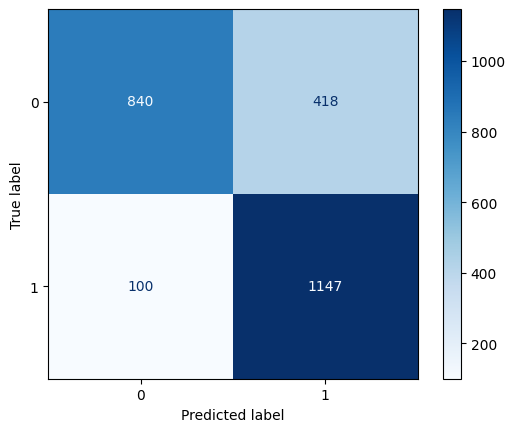

              precision    recall  f1-score   support

           0       0.89      0.67      0.76      1258
           1       0.73      0.92      0.82      1247

    accuracy                           0.79      2505
   macro avg       0.81      0.79      0.79      2505
weighted avg       0.81      0.79      0.79      2505

0.7932135728542914
0.8157894736842105
0.7329073482428115
0.9198075380914194
0.6677265500794912
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7932135462760925
         test_f1            0.8157894611358643
     test_precision         0.7329073548316956
       test_recall          0.9198075532913208
────────────────────────────────────────────────────────────────────────────────────────────────────────

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]




 TESTE IDRID 




Testing: |                                                                                                    …

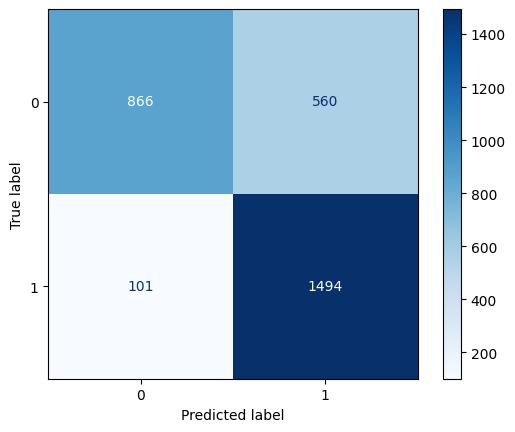

              precision    recall  f1-score   support

           0       0.90      0.61      0.72      1426
           1       0.73      0.94      0.82      1595

    accuracy                           0.78      3021
   macro avg       0.81      0.77      0.77      3021
weighted avg       0.81      0.78      0.77      3021

0.7811982787156571
0.8188544806796383
0.7273612463485881
0.9366771159874608
0.6072931276297335
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.781198263168335
         test_f1            0.8188544511795044
     test_precision          0.727361261844635
       test_recall           0.936677098274231
────────────────────────────────────────────────────────────────────────────────────────────────────────

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params
-------------------------------------------------
0 | model       | VGG              | 134 M 
1 | loss_module | CrossEntropyLoss | 0     
-------------------------------------------------
8.2 K     Trainable params
134 M     Non-trainable params
134 M     Total params
537.109   Total estimated model params size (MB)


FOLD 1
--------------------------------


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=15` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]




 TEST FOLD 1




Testing: |                                                                                                    …

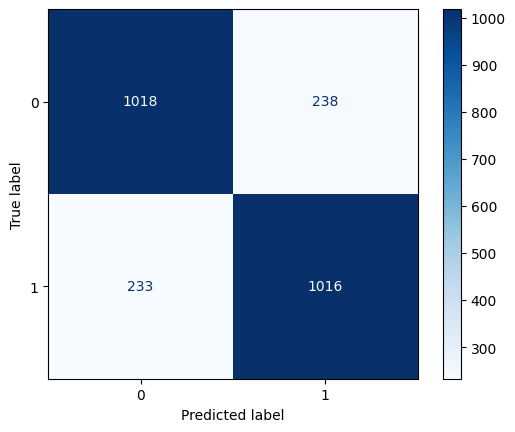

              precision    recall  f1-score   support

           0       0.81      0.81      0.81      1256
           1       0.81      0.81      0.81      1249

    accuracy                           0.81      2505
   macro avg       0.81      0.81      0.81      2505
weighted avg       0.81      0.81      0.81      2505

0.8119760479041916
0.811825809029165
0.810207336523126
0.8134507606084868
0.8105095541401274
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8119760751724243
         test_f1            0.8118258118629456
     test_precision         0.8102073073387146
       test_recall          0.8134507536888123
──────────────────────────────────────────────────────────────────────────────────────────────────────────

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]




 TESTE IDRID 




Testing: |                                                                                                    …

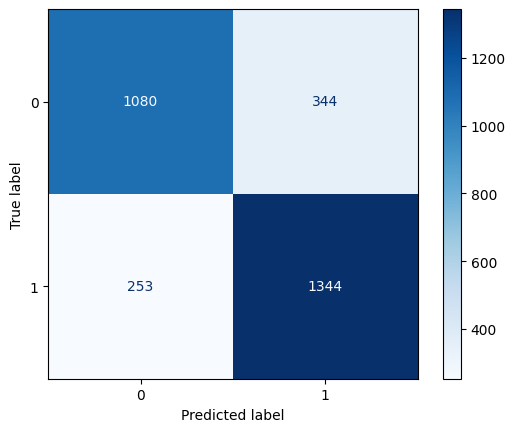

              precision    recall  f1-score   support

           0       0.81      0.76      0.78      1424
           1       0.80      0.84      0.82      1597

    accuracy                           0.80      3021
   macro avg       0.80      0.80      0.80      3021
weighted avg       0.80      0.80      0.80      3021

0.8023833167825224
0.8182648401826484
0.7962085308056872
0.841577958672511
0.7584269662921348
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.802383303642273
         test_f1            0.8182648420333862
     test_precision         0.7962085604667664
       test_recall           0.84157794713974
──────────────────────────────────────────────────────────────────────────────────────────────────────────

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


FOLD 2
--------------------------------



  | Name        | Type             | Params
-------------------------------------------------
0 | model       | VGG              | 134 M 
1 | loss_module | CrossEntropyLoss | 0     
-------------------------------------------------
8.2 K     Trainable params
134 M     Non-trainable params
134 M     Total params
537.109   Total estimated model params size (MB)


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=15` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]




 TEST FOLD 2




Testing: |                                                                                                    …

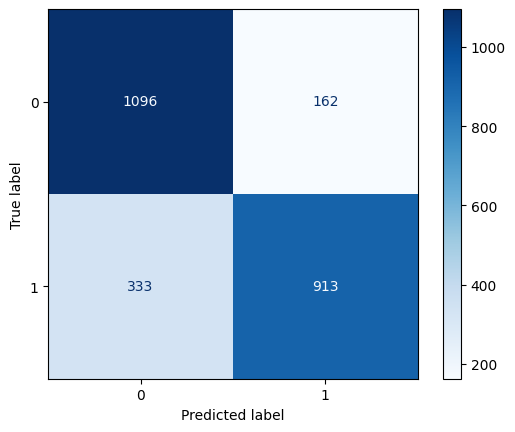

              precision    recall  f1-score   support

           0       0.77      0.87      0.82      1258
           1       0.85      0.73      0.79      1246

    accuracy                           0.80      2504
   macro avg       0.81      0.80      0.80      2504
weighted avg       0.81      0.80      0.80      2504

0.8023162939297125
0.7867298578199052
0.8493023255813954
0.7327447833065811
0.8712241653418124
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8023163080215454
         test_f1            0.7867298722267151
     test_precision          0.849302351474762
       test_recall          0.7327448129653931
────────────────────────────────────────────────────────────────────────────────────────────────────────

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]




 TESTE IDRID 




Testing: |                                                                                                    …

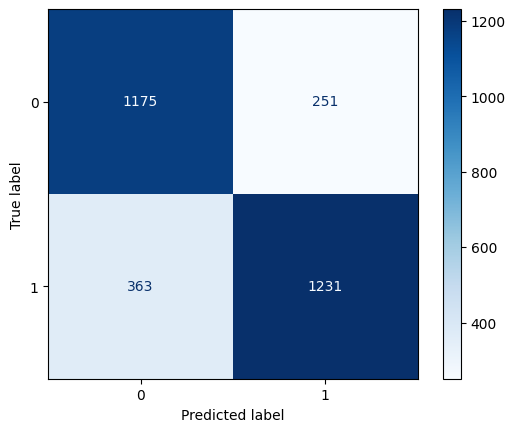

              precision    recall  f1-score   support

           0       0.76      0.82      0.79      1426
           1       0.83      0.77      0.80      1594

    accuracy                           0.80      3020
   macro avg       0.80      0.80      0.80      3020
weighted avg       0.80      0.80      0.80      3020

0.7966887417218543
0.8003901170351105
0.8306342780026991
0.7722710163111669
0.8239831697054698
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7966887354850769
         test_f1            0.8003901243209839
     test_precision         0.8306342959403992
       test_recall          0.7722710371017456
────────────────────────────────────────────────────────────────────────────────────────────────────────

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params
-------------------------------------------------
0 | model       | VGG              | 134 M 
1 | loss_module | CrossEntropyLoss | 0     
-------------------------------------------------
8.2 K     Trainable params
134 M     Non-trainable params
134 M     Total params
537.109   Total estimated model params size (MB)


FOLD 3
--------------------------------


Training: |                                                                                                   …

In [ ]:
from lightning.pytorch.loggers import TensorBoardLogger
from sklearn.model_selection import KFold

kfold = KFold(n_splits=k_folds, shuffle=True, random_state=random_state)

for fold, (train_ids, test_ids) in enumerate(kfold.split(ddr_dataset)):
    print(f'FOLD {fold}')
    print('--------------------------------')
    # Divide os dados com base nos atuais indices do K-fold
    train_dataset = torch.utils.data.Subset(ddr_dataset, train_ids)
    test_dataset = torch.utils.data.Subset(ddr_dataset, test_ids)


    # Definição dos dataloaders
    trainloader = torch.utils.data.DataLoader(
                      train_dataset,
                      batch_size=batch_size,
                      shuffle=True,
                      num_workers=20)
    testloader = torch.utils.data.DataLoader(
                      test_dataset,
                      batch_size=batch_size,
                      shuffle=False,
                      num_workers=20)
    idridloader = torch.utils.data.DataLoader(
                      idrid_dataset,
                      batch_size=batch_size,
                      num_workers=20)

    # DEBUG:
    # trainer = L.Trainer(fast_dev_run=4) # a execução do trainer se limitará a 2 batches
    # trainer = L.Trainer(limit_train_batches=30, max_epochs=1) # usar apenas 30% dos dados de cada lote de treino
    trainer = L.Trainer(default_root_dir='checkpoints kfold/', accelerator='gpu', max_epochs=num_epochs)


    
    # treino
    vgg16_model = ClassificationModule(vgg16, loss_function, optim.Adam)
    trainer.fit(model=vgg16_model, train_dataloaders=trainloader)
    # teste
    print(f'\n\n TEST FOLD {fold}\n\n')    
    trainer.test(model=vgg16_model, dataloaders=testloader) # test na fold de test 
    print('\n\n TESTE IDRID \n\n')    
    trainer.test(model=vgg16_model, dataloaders=idridloader) # test no idrid
    

##### ResNet50

In [ ]:
# Instanciação ResNet50
res50_best_weights = models.ResNet50_Weights.DEFAULT
res50_model = models.resnet50(weights=res50_best_weights)
res50_preprocess = res50_best_weights.transforms()


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 62.6MB/s]


In [ ]:
res50_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

##### MobileNet-V2



In [ ]:
# Instanciação MobileNetv2
mobv2_best_weights = models.MobileNet_V2_Weights.DEFAULT
mobv2_model = models.mobilenet_v2(weights=mobv2_best_weights)
mobv2_preprocess = mobv2_best_weights.transforms()

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 51.2MB/s]


In [ ]:
mobv2_model

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

##### EfficientNet-b7

In [ ]:
# Instanciação EfficientNetB7
effcb7_best_weights = models.EfficientNet_B7_Weights.DEFAULT
effcb7_model = models.efficientnet_b7(weights=effcb7_best_weights)
effcb7_preprocess = effcb7_best_weights.transforms()

Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-c5b4e57e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-c5b4e57e.pth
100%|██████████| 255M/255M [00:05<00:00, 50.6MB/s]


In [ ]:
effcb7_model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
            (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

In [ ]:
preprocess(tensor_test.permute(2, 0, 1))

tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1008, -2.1179, -2.1008],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1008, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1008, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1008, -2.1179],
         [-2.1179, -2.1008, -2.1179,  ..., -2.1179, -2.0837, -2.1179]],

        [[-2.0007, -2.0007, -2.0182,  ..., -2.0007, -2.0182, -2.0007],
         [-2.0182, -2.0007, -2.0007,  ..., -2.0182, -2.0182, -2.0007],
         [-2.0007, -2.0007, -2.0182,  ..., -2.0182, -2.0182, -2.0182],
         ...,
         [-2.0007, -2.0182, -2.0007,  ..., -2.0182, -2.0182, -2.0182],
         [-2.0007, -2.0182, -2.0182,  ..., -2.0182, -2.0182, -2.0182],
         [-2.0182, -2.0182, -2.0182,  ..., -2.0357, -2.0182, -2.0182]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ..., -1